In [321]:
import tensorflow as tf
import numpy as np

model_file = 'face_detection_front.tflite'
interpreter = tf.lite.Interpreter(
    model_path=model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# print(f'input_details {input_details}')
print(f'output_details {output_details}')

output_details [{'name': 'regressors', 'index': 175, 'shape': array([  1, 896,  16], dtype=int32), 'shape_signature': array([  1, 896,  16], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'classificators', 'index': 174, 'shape': array([  1, 896,   1], dtype=int32), 'shape_signature': array([  1, 896,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


(1, 128, 128, 3)

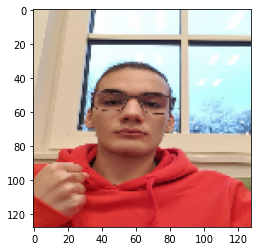

In [322]:
import cv2
import matplotlib.pyplot as plt

dim =  128
image = cv2.imread('mitio.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)

# plt.imshow(image[:,:,::-1])

image_cropped = image[:image.shape[0], :image.shape[0], ::-1] # crop to avoid letterboxing step
# plt.imshow(image_cropped)

img = cv2.resize(image_cropped, ( dim,  dim))[np.newaxis, :, :, :]

plt.imshow(img[0])

img = (np.float32(img) - 0.0) / 255.0  # normalization (specified in tflite_converter_calculator, not in model card)
img_input = (img - 0.5) / 0.5
#img = (np.float32(img) - 0.0) / 255.0 # normalization (specified in tflite_converter_calculator, not in model card)
img_input.shape

Maybe this is better input parser

In [323]:

img = cv2.imread('metest.jpg')

img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_height, img_width, img_channels = img.shape


		# Input values should be from -1 to 1 with a size of  dim x  dim pixels for the fornt model
		# and 256 x 256 pixels for the back model

img = img / 255.0

img_resized = tf.image.resize(img, [  dim,  dim], 
									method='bicubic', preserve_aspect_ratio=False)

img_input = img_resized.numpy()
img_input = (img_input - 0.5) / 0.5

		# Adjust matrix dimenstions
reshape_img = img_input.reshape(1,  dim,  dim, img_channels)
tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)



In [324]:
interpreter.set_tensor(input_details[0]['index'], tensor)

interpreter.invoke()

output0 =  np.squeeze(interpreter.get_tensor(output_details[0]['index']))
output1 =  np.squeeze(interpreter.get_tensor(output_details[1]['index']))

output0[0]

array([ 1.7805822e-02, -2.0416029e-02,  2.9595543e+01,  2.9595144e+01,
       -3.6023955e+00, -3.8619859e+00,  2.8956118e+00, -5.0159163e+00,
       -9.5156497e-01, -5.9818447e-01, -1.3303008e+00,  4.7315550e+00,
       -8.7533264e+00, -9.3598282e-01,  9.5530910e+00, -2.4314039e+00],
      dtype=float32)

In [325]:
scoreThreshold = 0.7
iouThreshold = 0.3
sigmoidScoreThreshold = np.log(scoreThreshold/(1-scoreThreshold))

def filterDetections(output1):

		# Filter based on the score threshold before applying sigmoid function
		goodDetections = np.where(output1 > sigmoidScoreThreshold)[0]
		

		# Convert scores back from sigmoid values
		scores = 1.0 /(1.0 + np.exp(-output1[goodDetections]))

		return scores, goodDetections

scores, goodDetectionsIndices  = filterDetections(output1)



In [326]:
import math

class SsdAnchorsCalculatorOptions:
	def __init__(self, input_size_width, input_size_height, min_scale, max_scale
		, num_layers, feature_map_width, feature_map_height
		, strides, aspect_ratios, anchor_offset_x=0.5, anchor_offset_y=0.5
		, reduce_boxes_in_lowest_layer=False, interpolated_scale_aspect_ratio=1.0
		, fixed_anchor_size=False):
		# Size of input images.
		self.input_size_width = input_size_width
		self.input_size_height = input_size_height
		# Min and max scales for generating anchor boxes on feature maps.
		self.min_scale = min_scale
		self.max_scale = max_scale
		# The offset for the center of anchors. The value is in the scale of stride.
		# E.g. 0.5 meaning 0.5 * |current_stride| in pixels.
		self.anchor_offset_x = anchor_offset_x
		self.anchor_offset_y = anchor_offset_y
		# Number of output feature maps to generate the anchors on.
		self.num_layers = num_layers
		# Sizes of output feature maps to create anchors. Either feature_map size or
		# stride should be provided.
		self.feature_map_width = feature_map_width
		self.feature_map_height = feature_map_height
		self.feature_map_width_size = len(feature_map_width)
		self.feature_map_height_size = len(feature_map_height)
		# Strides of each output feature maps.
		self.strides = strides
		self.strides_size = len(strides)
		# List of different aspect ratio to generate anchors.
		self.aspect_ratios = aspect_ratios
		self.aspect_ratios_size = len(aspect_ratios)
		# A boolean to indicate whether the fixed 3 boxes per location is used in the lowest layer.
		self.reduce_boxes_in_lowest_layer = reduce_boxes_in_lowest_layer
		# An additional anchor is added with this aspect ratio and a scale
		# interpolated between the scale for a layer and the scale for the next layer
		# (1.0 for the last layer). This anchor is not included if this value is 0.
		self.interpolated_scale_aspect_ratio = interpolated_scale_aspect_ratio
		# Whether use fixed width and height (e.g. both 1.0f) for each anchor.
		# This option can be used when the predicted anchor width and height are in  pixels.
		self.fixed_anchor_size = fixed_anchor_size
	def to_string(self):
		return 'input_size_width: {:}\ninput_size_height: {:}\nmin_scale: {:}\nmax_scale: {:}\nanchor_offset_x: {:}\nanchor_offset_y: {:}\nnum_layers: {:}\nfeature_map_width: {:}\nfeature_map_height: {:}\nstrides: {:}\naspect_ratios: {:}\nreduce_boxes_in_lowest_layer: {:}\ninterpolated_scale_aspect_ratio: {:}\nfixed_anchor_size: {:}'\
		.format(self.input_size_width, self.input_size_height, self.min_scale, self.max_scale
			, self.anchor_offset_x, self.anchor_offset_y, self.num_layers
			, self.feature_map_width, self.feature_map_height, self.strides, self.aspect_ratios
			, self.reduce_boxes_in_lowest_layer, self.interpolated_scale_aspect_ratio
			, self.fixed_anchor_size)

class Anchor:
	def __init__(self, x_center, y_center, h, w):
		self.x_center = x_center
		self.y_center = y_center
		self.h = h
		self.w = w
	def to_string(self):
		return 'x_center: {:}, y_center: {:}, h: {:}, w: {:}'.format(self.x_center, self.y_center, self.h, self.w)

def gen_anchors(options):
	anchors = []
	# Verify the options.
	if (options.strides_size != options.num_layers):
		print("strides_size and num_layers must be equal.")
		return []

	layer_id = 0
	while (layer_id < options.strides_size):
		anchor_height = []
		anchor_width = []
		aspect_ratios = []
		scales = []

		# For same strides, we merge the anchors in the same order.
		last_same_stride_layer = layer_id
		while (last_same_stride_layer < options.strides_size and options.strides[last_same_stride_layer] == options.strides[layer_id]):
			scale = options.min_scale + (options.max_scale - options.min_scale) * 1.0 * last_same_stride_layer / (options.strides_size - 1.0)
			if (last_same_stride_layer == 0 and options.reduce_boxes_in_lowest_layer):
				# For first layer, it can be specified to use predefined anchors.
				aspect_ratios.append(1.0)
				aspect_ratios.append(2.0)
				aspect_ratios.append(0.5)
				scales.append(0.1)
				scales.append(scale)
				scales.append(scale)
			else:
				for aspect_ratio_id in range(options.aspect_ratios_size):
					aspect_ratios.append(options.aspect_ratios[aspect_ratio_id])
					scales.append(scale)
				
				if (options.interpolated_scale_aspect_ratio > 0.0):
					scale_next = 1.0 if last_same_stride_layer == options.strides_size - 1 else options.min_scale + (options.max_scale - options.min_scale) * 1.0 * (last_same_stride_layer+1) / (options.strides_size - 1.0)
					scales.append(math.sqrt(scale * scale_next))
					aspect_ratios.append(options.interpolated_scale_aspect_ratio)
			last_same_stride_layer += 1
		for i in range(len(aspect_ratios)):
			ratio_sqrts = math.sqrt(aspect_ratios[i])
			anchor_height.append(scales[i] / ratio_sqrts)
			anchor_width.append(scales[i] * ratio_sqrts)

		feature_map_height = 0
		feature_map_width = 0
		if (options.feature_map_height_size > 0):
			feature_map_height = options.feature_map_height[layer_id]
			feature_map_width = options.feature_map_width[layer_id]
		else:
			stride = options.strides[layer_id]
			feature_map_height = math.ceil(1.0 * options.input_size_height / stride)
			feature_map_width = math.ceil(1.0 * options.input_size_width / stride)

		for y in range(feature_map_height):
			for x in range(feature_map_width):
				for anchor_id in range(len(anchor_height)):
					# TODO: Support specifying anchor_offset_x, anchor_offset_y.
					x_center = (x + options.anchor_offset_x) * 1.0 / feature_map_width
					y_center = (y + options.anchor_offset_y) * 1.0 / feature_map_height
					w = 0
					h = 0
					if (options.fixed_anchor_size):
						w = 1.0
						h = 1.0
					else:
						w = anchor_width[anchor_id]
						h = anchor_height[anchor_id]
					new_anchor = Anchor(x_center, y_center, h, w)
					anchors.append(new_anchor)
		layer_id = last_same_stride_layer
	return anchors

In [327]:
ssd_anchors_calculator_options = SsdAnchorsCalculatorOptions(input_size_width=128, input_size_height=128, min_scale=0.1484375, max_scale=0.75
					, anchor_offset_x=0.5, anchor_offset_y=0.5, num_layers=4
					, feature_map_width=[], feature_map_height=[]
					, strides=[8, 16, 16, 16], aspect_ratios=[1.0]
					, reduce_boxes_in_lowest_layer=False, interpolated_scale_aspect_ratio=1.0
					, fixed_anchor_size=True)
anchors = gen_anchors(ssd_anchors_calculator_options)


In [328]:
KEY_POINT_SIZE = 6
def extractDetections( output0, goodDetectionsIndices):

		numGoodDetections = goodDetectionsIndices.shape[0]
	

		keypoints = np.zeros((numGoodDetections, KEY_POINT_SIZE, 2))
		boxes = np.zeros((numGoodDetections, 4))
		
		for idx, detectionIdx in enumerate(goodDetectionsIndices):
			anchor =  anchors[detectionIdx]
			
			sx = output0[detectionIdx, 0]
			sy = output0[detectionIdx, 1]
			w = output0[detectionIdx, 2]
			h = output0[detectionIdx, 3]


			cx = sx + anchor.x_center *   dim
			cy = sy + anchor.y_center *   dim

			cx /=   dim
			cy /=   dim
			w /=   dim
			h /=   dim

			for j in range(KEY_POINT_SIZE):
				lx = output0[detectionIdx, 4 + (2 * j) + 0]
				ly = output0[detectionIdx, 4 + (2 * j) + 1]
				lx += anchor.x_center *   dim
				ly += anchor.y_center *   dim
				lx /=   dim
				ly /=   dim
				keypoints[idx,j,:] = np.array([lx, ly])

			boxes[idx,:] = np.array([cx - w * 0.5, cy - h * 0.5, cx + w * 0.5, cy + h * 0.5])

		return boxes, keypoints
boxes, keypoints = extractDetections(output0, goodDetectionsIndices)
print(goodDetectionsIndices)

[239 269 271 303 722]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)
(64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


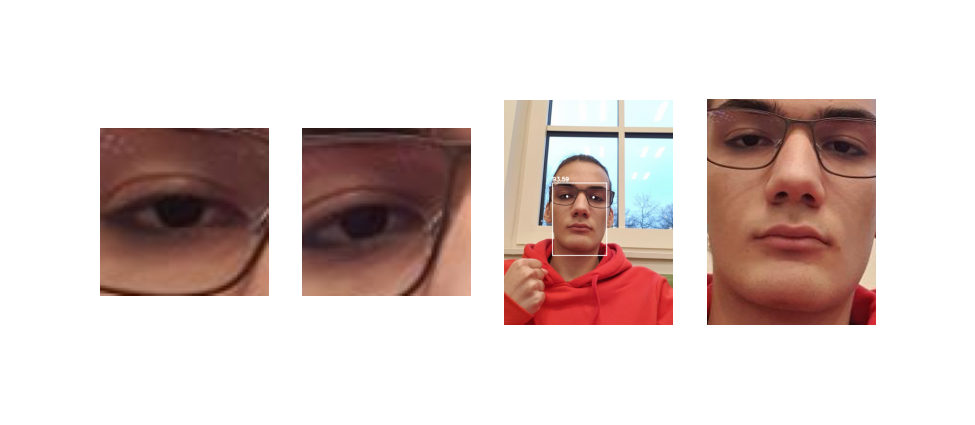

In [329]:
# for boundingBox in boxes:
#     x1 = (img_width * boundingBox[0]).astype(int)
#     x2 = (img_width * boundingBox[2]).astype(int)
#     y1 = (img_height * boundingBox[1]).astype(int)
#     y2 = (img_height * boundingBox[3]).astype(int)

#     cv2.rectangle(img, (x1, y1), (x2, y2), (22, 22, 250), 2)
#     cv2.putText(img, '{:.2f}'.format(100), (x1, y1 - 6)
# 								, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (22, 22, 250), 2)
                            
# for i in range(0,5):
#     for j in range(0,6):
#         xKeypoint = (keypoints[i,j,0] * img_width).astype(int)
#         yKeypoint = (keypoints[i,j,1] * img_height).astype(int)
#         cv2.circle(img,(xKeypoint,yKeypoint), 4, (214, 202, 18), -1)
import copy
fig=plt.figure(figsize=(1,4), dpi=1000)
maxScore = 0

drawImg = copy.copy(img)

for i in range(0,scores.size):
    if scores[i]>scores[maxScore]:
        maxScore = i

x1 = (img_width *  boxes[maxScore,0]).astype(int)
x2 = (img_width * boxes[maxScore,2]).astype(int)
y1 = (img_height * boxes[maxScore,1]).astype(int)
y2 = (img_height * boxes[maxScore,3]).astype(int)

fig.add_subplot(1,4, 4)
plt.imshow(img[y1:y2, x1:x2,0:3]) 

plt.axis("off")       

cv2.rectangle(drawImg, (x1, y1), (x2, y2), (22, 22, 250), 2)
cv2.putText(drawImg, '{:.2f}'.format(scores[maxScore]*100), (x1, y1 - 6)
								, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (22, 22, 250), 2)


                    
w = (boxes[maxScore,2]-boxes[maxScore,0])/3*img_width
h = (boxes[maxScore,3]-boxes[maxScore,1])/4*img_height
center = img.shape
crop_img = []

for j in range(0,2):
    xKeypoint = (keypoints[maxScore,j,0] * img_width).astype(int)
    yKeypoint = (keypoints[maxScore,j,1] * img_height).astype(int)
    cv2.circle(drawImg,(xKeypoint,yKeypoint), 4, (214, 202, 18), -1)

    crop_img = img[int(yKeypoint-h/2):int(yKeypoint+h/2), int(xKeypoint-w/2):int(xKeypoint+w/2), 0:3]
    fig.add_subplot(1,4, j+1)
    if j == 1:crop_img = cv2.flip(crop_img, 1)
    crop_img = tf.image.resize(crop_img, [  64,  64], 
									method='bicubic', preserve_aspect_ratio=False)
    print(crop_img.shape)
    cv2.imwrite(f"eye{j}.jpg",np.float32(crop_img)*255)
    plt.imshow(crop_img)
    plt.axis("off")

fig.add_subplot(1,4, 3)
plt.imshow(drawImg) 
plt.axis("off")       

plt.show()
        

In [330]:
# class Results:
# 	def __init__(self, boxes, keypoints, scores):
# 		boxes = boxes
# 		keypoints = keypoints
# 		scores = scores
# def filterWithNonMaxSupression( boxes, keypoints, scores):
# 		# Filter based on non max suppression
# 		selected_indices = tf.image.non_max_suppression(boxes, scores, 1, iouThreshold)
# 		filtered_boxes = tf.gather(boxes, selected_indices).numpy()
# 		filtered_keypoints = tf.gather(keypoints, selected_indices).numpy()
# 		filtered_scores = tf.gather(scores, selected_indices).numpy()

# 		detectionResults = Results(filtered_boxes, filtered_keypoints, filtered_scores)
# 		return detectionResults

# detectionResults = filterWithNonMaxSupression(boxes, keypoints, scores)
# scores

In [331]:
# import tensorflow as tf
# import numpy as np

# img = np.random.randint(0, 256, (1,64,64,3), np.uint8)

# img = (np.float32(img) - 0.0) / 255.0 # normalization (specified in tflite_converter_calculator, not in model card)

# model_file = 'iris_landmark.tflite'
# interpreter = tf.lite.Interpreter(
#     model_path=model_file)
# interpreter.allocate_tensors()

# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print(f'input_details {input_details}')
# print(f'output_details {output_details}')

# # check the type of the input tensor
# floating_model = input_details[0]['dtype'] == np.float32
# print(f'is floating model: {floating_model}')

# # NxHxWxC, H:1, W:2
# height = input_details[0]['shape'][1]
# width = input_details[0]['shape'][2]

# interpreter.set_tensor(input_details[0]['index'], img)

# interpreter.invoke()

# output_eyes = interpreter.get_tensor(output_details[0]['index'])[0]
# output_iris = interpreter.get_tensor(output_details[1]['index'])[0]

In [332]:
# import cv2
# import matplotlib.pyplot as plt

# # image = cv2.imread('000078ZOOMED.jpg')
# image = crop_img
# image = np.float32(image)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image[:,:,::-1])

# image_cropped = image[:image.shape[0], :image.shape[0], ::-1] # crop to avoid letterboxing step
# plt.imshow(image_cropped)

# img = cv2.resize(image_cropped, (64, 64))[np.newaxis, :, :, :]
# img = (np.float32(img) - 0.0) / 255.0  # normalization (specified in tflite_converter_calculator, not in model card)

# #img = (np.float32(img) - 0.0) / 255.0 # normalization (specified in tflite_converter_calculator, not in model card)
# interpreter.set_tensor(input_details[0]['index'], img)

# interpreter.invoke()

# output_eyes = interpreter.get_tensor(output_details[0]['index'])[0]
# output_iris = interpreter.get_tensor(output_details[1]['index'])[0]

# print(f'output iris landmarks x {output_iris[::3]/64.0}') # tflite_tensors_to_landmarks_calculator normalization
# print(f'output iris landmarks y {output_iris[1::3]/64.0}')

# # cropped image
# plt.imshow(image_cropped)
# plt.plot(output_iris[::3]/64.0*image_cropped.shape[0], (1-output_iris[1::3]/64.0)*image_cropped.shape[1], '*')